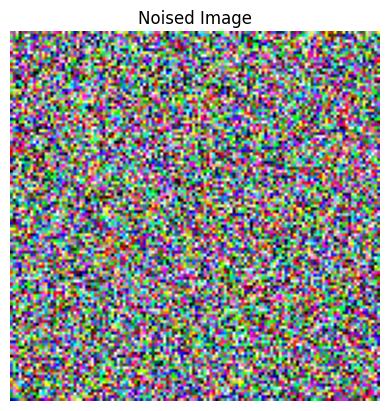

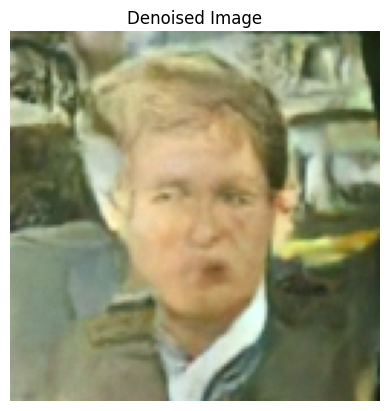

In [ ]:
# please comment out once downloaded once to avoid re-downloading at each run !
!wget https://perso.liris.cnrs.fr/nicolas.bonneel/cours/unets.py
!wget https://perso.liris.cnrs.fr/nicolas.bonneel/cours/fullmodel_unetsmall_faces.pt
#!wget https://perso.liris.cnrs.fr/nicolas.bonneel/cours/fullmodel_unetsmall_photos.pt
#!wget https://perso.liris.cnrs.fr/nicolas.bonneel/cours/fullmodel_unet_faces.pt


import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import time
from mpl_toolkits.axes_grid1 import ImageGrid
import unets

t_max = 500  # 1000 for unet_faces, 500 for unetsmall_faces, or 200 for the photo dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = unets.UNetSmall(image_size=128, in_channels=3, out_channels=3, num_classes=None).to(device)

alpha_t_vec = 1-np.linspace(0.0001, 0.02, t_max)
alpha_bar_t_vec = np.cumprod(alpha_t_vec)

checkpoint = torch.load("./fullmodel_unetsmall_faces.pt", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

training = False
if training:
    resize_transform = transforms.Compose([ transforms.Resize(size=(128,128)), transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32) ]);

    dataset = datasets.ImageFolder(root = "./data",
                             transform = resize_transform)

    loader = torch.utils.data.DataLoader(dataset = dataset,
                                        batch_size = 1,
                                        shuffle = True)
    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

    prefetched_images = []
    for (image, _) in loader:
        prefetched_images.append(np.squeeze(image*2.0-1.0))

    epochs =  int(2505*12)
    outputs = []
    losses = []
    batch_size = 8

    start_time = time.time()
    for epoch in range(epochs):
        random.shuffle(prefetched_images)

        #for i in range(0, int(4936/batch_size) ):
        for i in range(0, int(48/batch_size) ):
            batch = prefetched_images[(i*batch_size):(i*batch_size+batch_size)]
            image = torch.stack(batch, dim=0)
            img = image.to(device)
            t = np.random.random_integers(0, t_max-1, size=(batch_size))

            eps_0_t = torch.randn(img.size(), device=device)
            alpha_bar_t = torch.from_numpy(alpha_bar_t_vec[t]).to(device=device).view((batch_size, 1, 1, 1)).float()
            noisy_img = torch.sqrt(alpha_bar_t) * img + torch.sqrt(1-alpha_bar_t)*eps_0_t

            predicted_noise_value = model(noisy_img, torch.from_numpy(t).float().to(device=device))

            loss = loss_function(predicted_noise_value, eps_0_t)

            reconstructed = (noisy_img - torch.sqrt(1-alpha_bar_t)*predicted_noise_value)/torch.sqrt(alpha_bar_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.cpu().detach())

    print("--- %s seconds ---" % (time.time() - start_time))

    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, "./fullmodel.pt")


    plt.figure(0)

    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.plot(losses[10:])

    # Show noisy images
    fig = plt.figure(1, figsize=(6, 6))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.01,
                 )
    for i, (ax, item)  in enumerate(zip(grid, noisy_img.cpu().detach())):
        if i==16:
            break
        item = (np.transpose(item.reshape(3, 128, 128), (1,2,0))+1.0)/2.0
        ax.imshow(item)

    # Show denoised images
    fig = plt.figure(2, figsize=(6, 6))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.01,
                 )

    for i, (ax, item) in enumerate(zip(grid , reconstructed.cpu().detach())):
        if i==16:
            break
        item = (np.transpose(item.reshape(3, 128, 128),(1,2,0))+1.0)/2.0
        ax.imshow(item)


noisy_stuff = torch.randn((1,3,128,128), device=device)

denoised_stuff = noisy_stuff

model.eval()
with torch.no_grad():
  # loop over time and progressively denoise your randn
    for step in reversed(range(t_max)):

        alpha_t = torch.tensor(alpha_t_vec[step], device=device).float()
        alpha_bar_t = torch.tensor(alpha_bar_t_vec[step], device=device).float()

        # Predict noise at this step
        predicted_noise_value = model(denoised_stuff, torch.tensor([step], device=device).float())

        # Denoising step
        part = (denoised_stuff - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise_value) / torch.sqrt(alpha_t)

        # gaussian_noise
        gaussian_noise = torch.randn_like(denoised_stuff, device=device)

        denoised_stuff = part + gaussian_noise * torch.sqrt((1 - alpha_t))


final_image = (noisy_stuff.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0  # Rescale to [0, 1]
plt.imshow(final_image.clip(0, 1))
plt.axis("off")
plt.title("Noised Image")
plt.show()

final_image = (denoised_stuff.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0  # Rescale to [0, 1]
plt.imshow(final_image.clip(0, 1))
plt.axis("off")
plt.title("Denoised Image")
plt.show()